# Generate Synthetic Data

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from typing import Tuple


def generate_scrolling_data(
    t, u, a=0.5, b=0.3, c=0.1, noise_std=0.05
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate synthetic data for a screen scrolling interaction.
    `t` and `u` are NumPy arrays representing time and input signal.
    """
    assert t is not None, "Time vector t must be provided"
    assert u.shape == t.shape, (
        "Input signal u must have the same shape as time vector t"
    )

    # Screen scroll dynamics in state space representation
    A = np.array([[0, 1], [-c / a, -b / a]])
    B = np.array([[0], [1 / a]])
    C = np.array([[1, 1]])
    D = np.array([[0]])

    sys = signal.StateSpace(A, B, C, D)

    # Simulate the system and add some noise
    t_out, y_clean, x = signal.lsim(sys, u, t)
    noise = np.random.normal(0, noise_std, y_clean.shape)
    y_noisy = y_clean + noise

    return t_out, u, x, y_noisy, y_clean

In [8]:
def generate_multiple_datasets(
    t, N=10, a=0.5, b=0.3, c=0.1, noise_std=0.05
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate multiple small datasets for estimating system parameters.
    """
    us = []
    ys = []
    xs = []

    # Generate multiple datasets with different input patterns
    for i in range(N):
        # Generate input signal by randomly turning on an off
        # the input signal every 10 time steps
        u = np.zeros_like(t)

        # Get a random integer
        d = np.random.randint(1, 10)
        for j in range(d):
            e = np.random.rand()
            if e < 0.33:
                u[j * d : (j + 1) * d] = 1.0
            elif e < 0.66:
                u[j * d : (j + 1) * d] = -1.0
            else:
                u[j * d : (j + 1) * d] = 0.0

        # Add some random noise to inputs
        u += np.random.normal(0, 0.1, size=t.shape)

        # Generate data
        t_out, u_out, x, y_noisy, y_clean = generate_scrolling_data(
            t, u, a, b, c, noise_std
        )

        us.append(u_out)
        ys.append(y_noisy)
        xs.append(x)

    return np.array(us), np.array(ys), np.array(xs)


np.random.seed(42)
ts = np.linspace(0, 50, 51)
N = 1
us, ys, xs = generate_multiple_datasets(ts, N)

print(us.shape, xs.shape)

(1, 51) (1, 51, 2)


/tmp/ipykernel_43703/3561257690.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


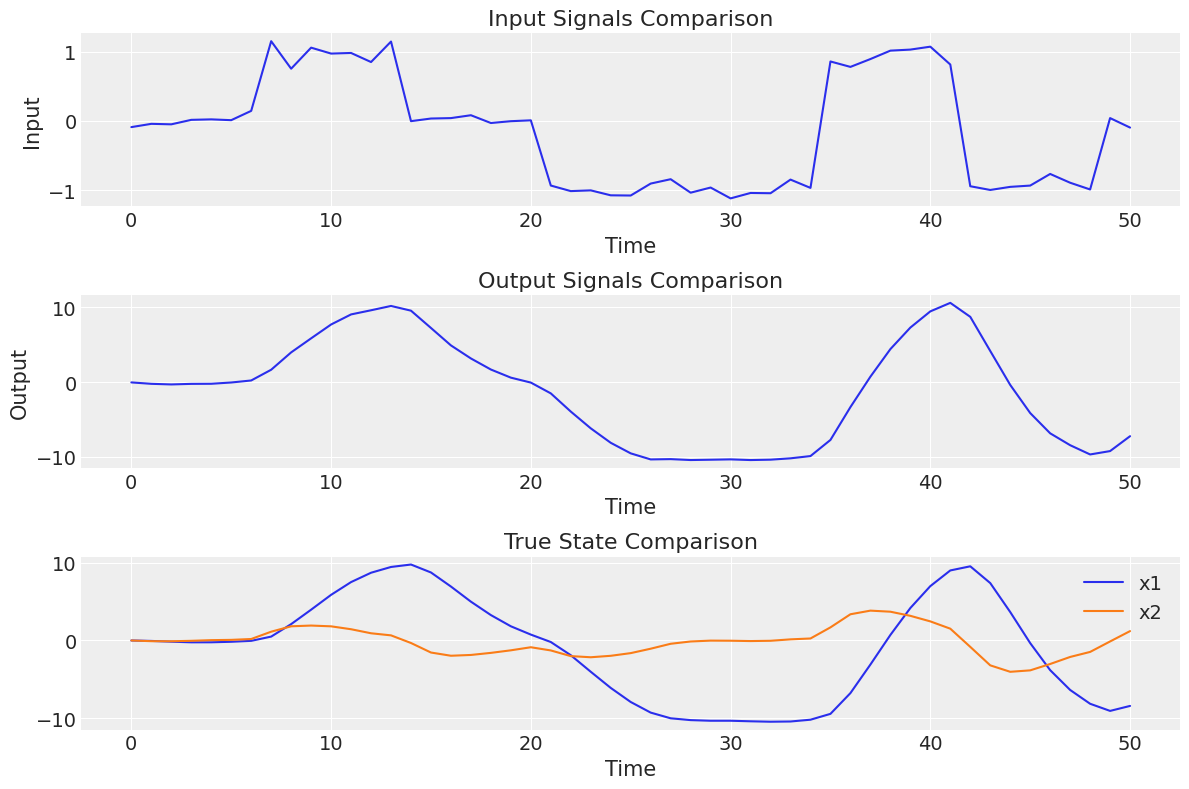

In [9]:
def plot_multiple_datasets(ts, us, ys, xs):
    """Generate and plot multiple datasets"""
    assert us.shape == ys.shape, "Input and output signals must have the same shape"

    N, T = us.shape
    fig = plt.figure(figsize=(12, 8))

    # Plot input signals
    plt.subplot(3, 1, 1)
    for i in range(N):
        plt.plot(ts, us[i, :])
    plt.title("Input Signals Comparison")
    plt.xlabel("Time")
    plt.ylabel("Input")

    # Plot output signals
    plt.subplot(3, 1, 2)
    for i in range(N):
        plt.plot(
            ts,
            ys[i, :],
            label=f"Dataset {i + 1}",
        )
    plt.title("Output Signals Comparison")
    plt.xlabel("Time")
    plt.ylabel("Output")

    # Plot true states
    plt.subplot(3, 1, 3)
    for i in range(N):
        plt.plot(ts, xs[i, :, 0])
        plt.plot(ts, xs[i, :, 1])

    plt.title("True State Comparison")
    plt.legend(["x1", "x2"])
    plt.xlabel("Time")

    plt.tight_layout()

    # Show all figures
    plt.show()

plot_multiple_datasets(ts, us, ys, xs)

# NumPyro Model

In [10]:
import os

import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.infer.util import initialize_model
import jax
import jax.numpy as jnp
from jax import random, lax
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.primitives import plate
from numpyro.infer import MCMC, NUTS

import arviz as az

az.style.use("arviz-darkgrid")

numpyro.set_platform("cpu")
numpyro.set_host_device_count(1)

In [11]:
np.random.seed(42)
ts = np.linspace(0, 50, 51)
N = 10
us, ys, xs = generate_multiple_datasets(ts, N, .5, .3, .1, 0.1)

Y = jnp.array(ys)
U = jnp.array(us)

print(Y.shape)
print(U.shape)

(10, 51)
(10, 51)


In [ ]:
def lgssm(U, Y):
    num_sequences, sequence_length = Y.shape

    assert U.shape[0] == num_sequences, "Number of sequences must match"
    assert U.shape[1] == sequence_length, "Sequence length must match"

    state_dim = 2

    # Parameters for the state space model
    a = numpyro.sample("a", dist.Exponential(1.0))
    b = numpyro.sample("b", dist.Exponential(1.0))
    c = numpyro.sample("c", dist.Exponential(1.0))

    A = jnp.array([[0, 1], [-c / a, -b / a]])
    B = jnp.array([[0], [1 / a]])
    C = jnp.array([[1.0, 0.0]])

    # LG-SSM adds noise to dynamics and observation
    qs = numpyro.sample("qs", dist.Exponential(1.0).expand([state_dim]))
    Q = jnp.diag(qs)
    r = numpyro.sample("r", dist.Exponential(1.0))

    # Process each sequence separately
    # TODO: Vectorize this code to speed it up.
    for i in range(num_sequences):
        u_seq = U[i]
        y_seq = Y[i]

        # Initial state and observation
        z0 = numpyro.sample(
            f"z0_{i}", dist.MultivariateNormal(jnp.zeros(state_dim), jnp.eye(state_dim))
        )

        y0_mu = jnp.squeeze(C @ z0)
        numpyro.sample(f"y0_{i}", dist.Normal(y0_mu, r), obs=y_seq[0])

        # A transition function for scanning over time steps
        def transition_fn(z_prev, t):
            u_t = u_seq[t]
            y_t = y_seq[t]

            # Apply dynamics and add noise to the state
            u_col = jnp.array([u_t])
            z_mu = A @ z_prev + B @ u_col
            z_t = numpyro.sample(
                f"z{i}_{t}",
                dist.MultivariateNormal(loc=z_mu, covariance_matrix=Q),
            )

            # Compute expected observation and add noise
            y_mu = jnp.squeeze(C @ z_t)
            numpyro.sample(f"y{i}_{t}", dist.Normal(y_mu, r), obs=y_t)

            return z_t, None

        # Scan throught the signals. Start from time step 1.
        _, _ = scan(transition_fn, z0, jnp.arange(1, sequence_length))


rng_key = random.PRNGKey(0)
kernel = NUTS(lgssm)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(rng_key=rng_key, U=U, Y=Y)


sample: 100%|██████████| 3000/3000 [03:21<00:00, 14.91it/s, 63 steps of size 7.76e-02. acc. prob=0.91]  


In [12]:
mcmc.print_summary()



                                                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                                                           a      0.13      0.00      0.13      0.12      0.13   1134.59      1.00
                                                           b      0.00      0.00      0.00      0.00      0.00   2157.56      1.00
                                                           c      0.00      0.00      0.00      0.00      0.00   2417.57      1.00
                                                       qs[0]      3.45      1.12      3.52      1.59      5.08     47.73      1.03
                                                       qs[1]      2.71      1.16      2.60      0.79      4.43     43.10      1.03
                                                           r      0.54      0.20      0.49      0.24      0.81     16.12      1.00
                                                     z0_0[0]     -0.08      0.47  

# Visualization

In [17]:
xs

array([[[  0.        ,   0.        ],
        [ -0.05849219,  -0.09028025],
        [ -0.15494587,  -0.10071758],
        ...,
        [ -8.1532023 ,  -1.47454519],
        [ -9.0727889 ,  -0.12584925],
        [ -8.43129721,   1.20838208]],

       [[  0.        ,   0.        ],
        [ -0.88177342,  -1.57577138],
        [ -2.78202628,  -2.05058108],
        ...,
        [  9.81805635,   0.01105323],
        [  9.8974491 ,   0.12249121],
        [ 10.01160116,   0.08099798]],

       [[  0.        ,   0.        ],
        [  0.81486974,   1.42221163],
        [  2.22056607,   1.01505952],
        ...,
        [ -0.23867806,   0.33235816],
        [  0.11969217,   0.28990035],
        [  0.28522813,   0.0640528 ]],

       ...,

       [[  0.        ,   0.        ],
        [  0.82983054,   1.46880859],
        [  2.63152598,   2.01635287],
        ...,
        [-10.60676258,   0.83122271],
        [ -9.07792354,   2.00147339],
        [ -6.86379404,   2.3730467 ]],

       [[  0.  

Parameter Estimates:
a: 0.1265 (true: 0.5000)
b: 0.0002 (true: 0.3000)
c: 0.0002 (true: 0.1000)
r: 0.5373 (true: 0.0500)
qs: [3.4539156 2.705385 ]


/tmp/ipykernel_43703/4173068057.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


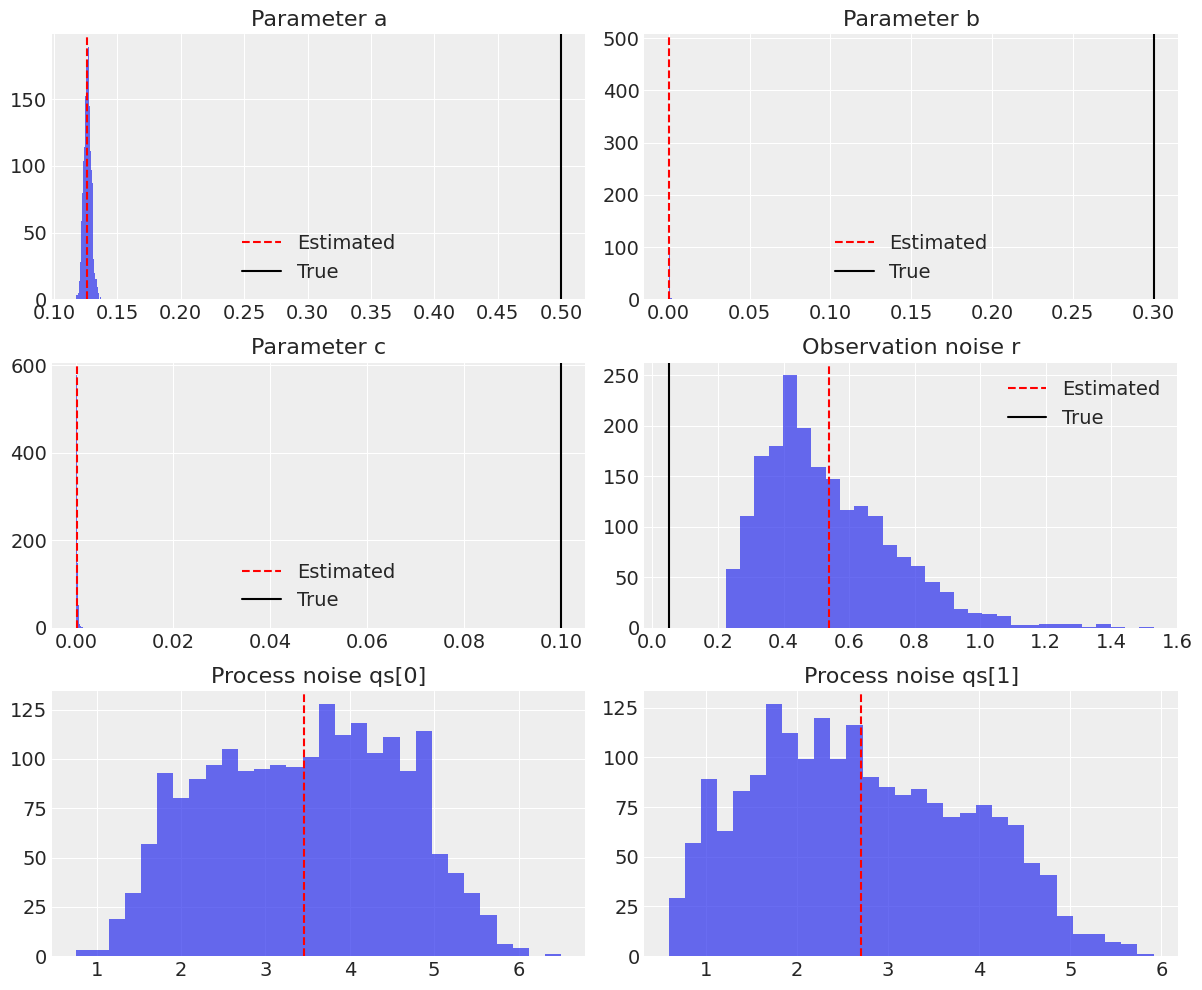

/tmp/ipykernel_43703/4173068057.py:169: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


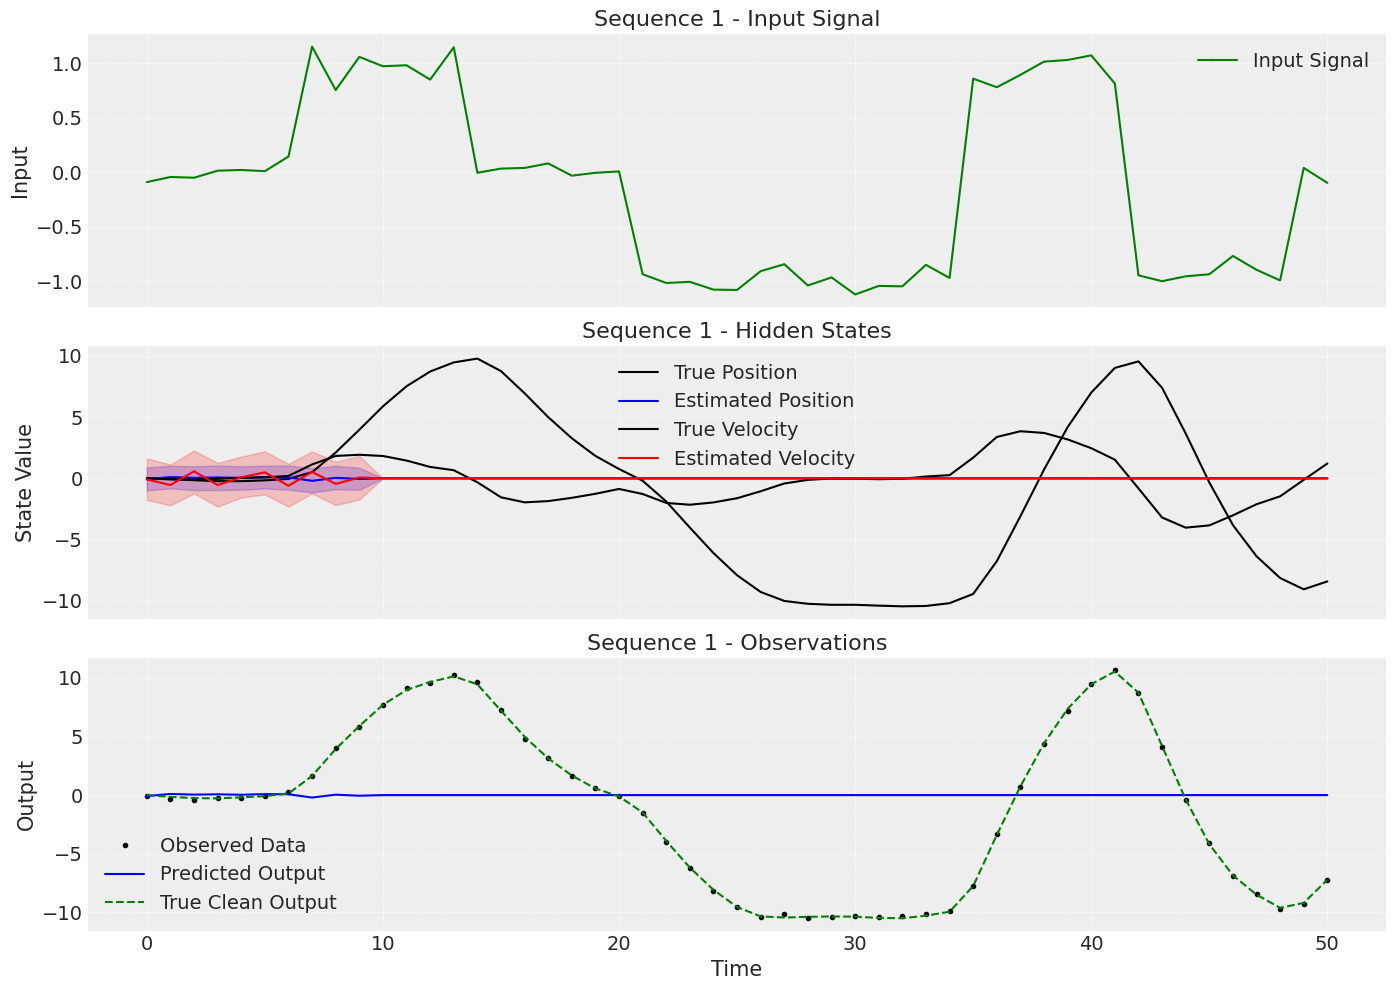

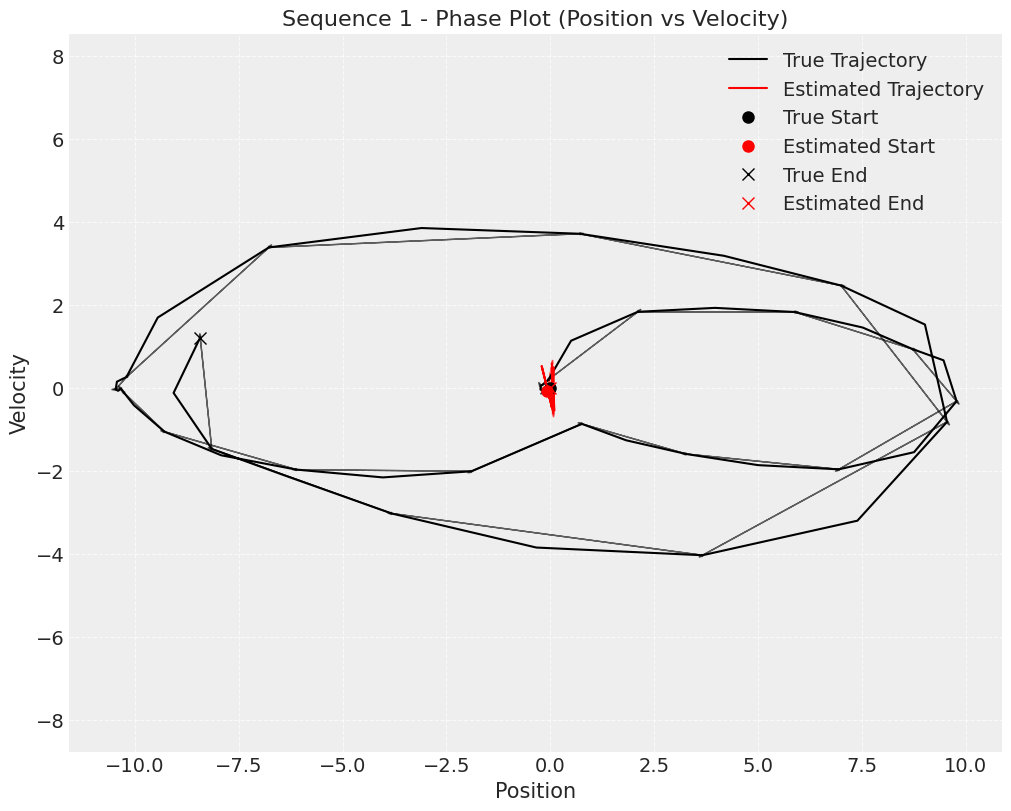

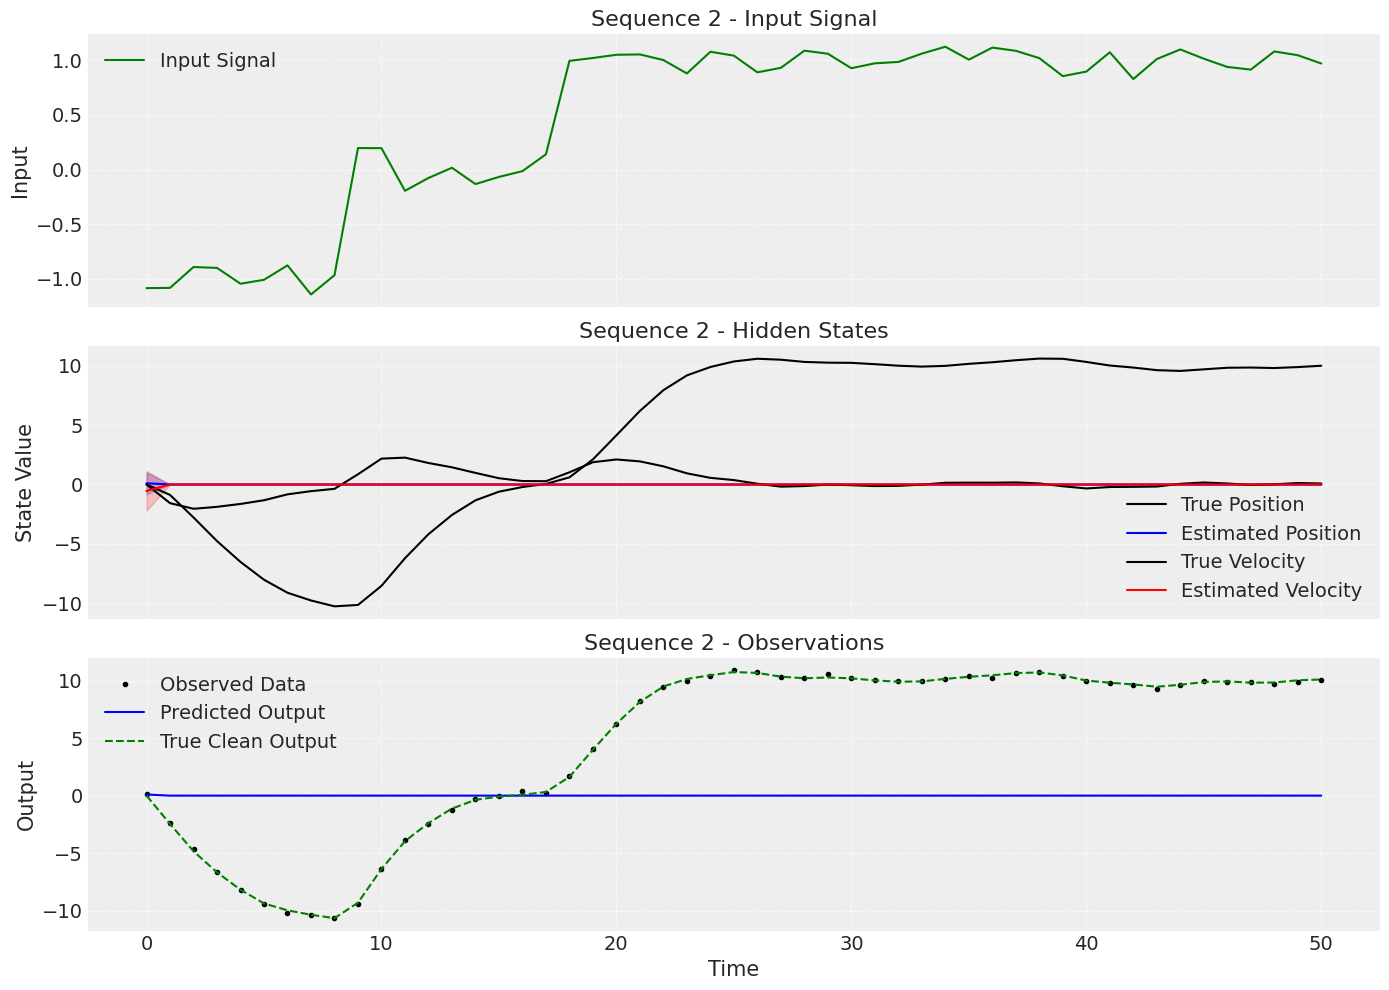

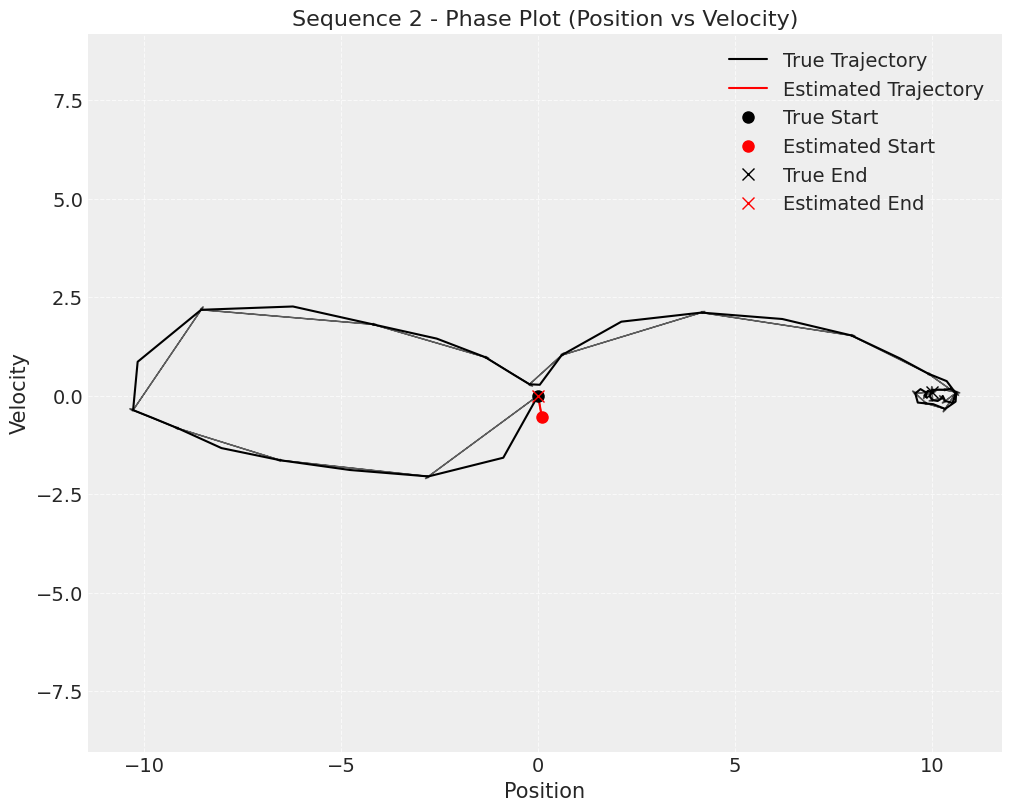

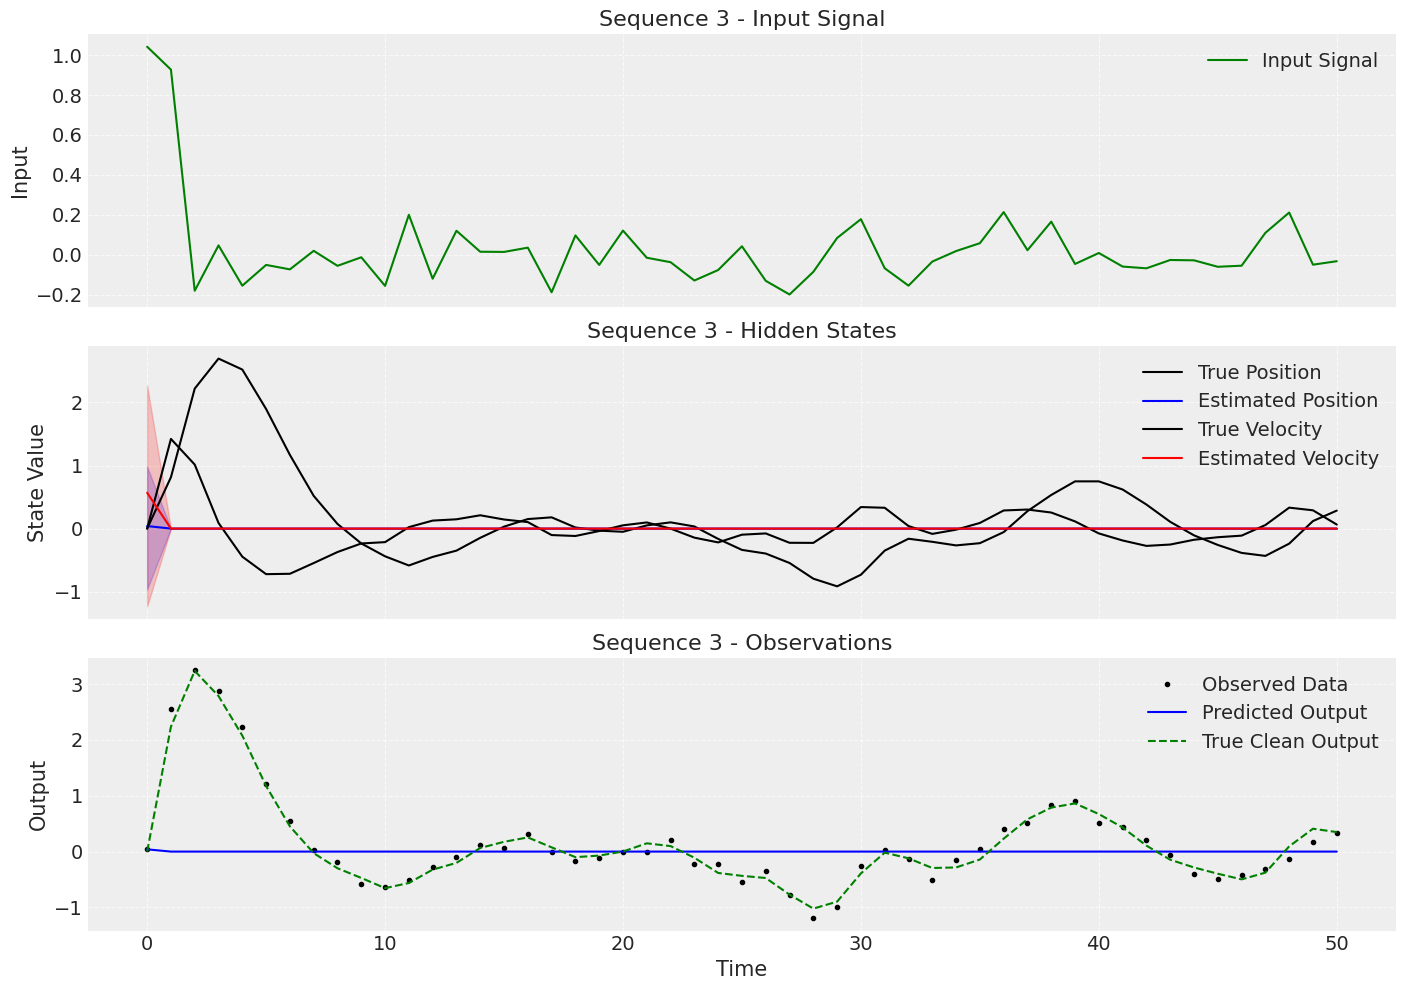

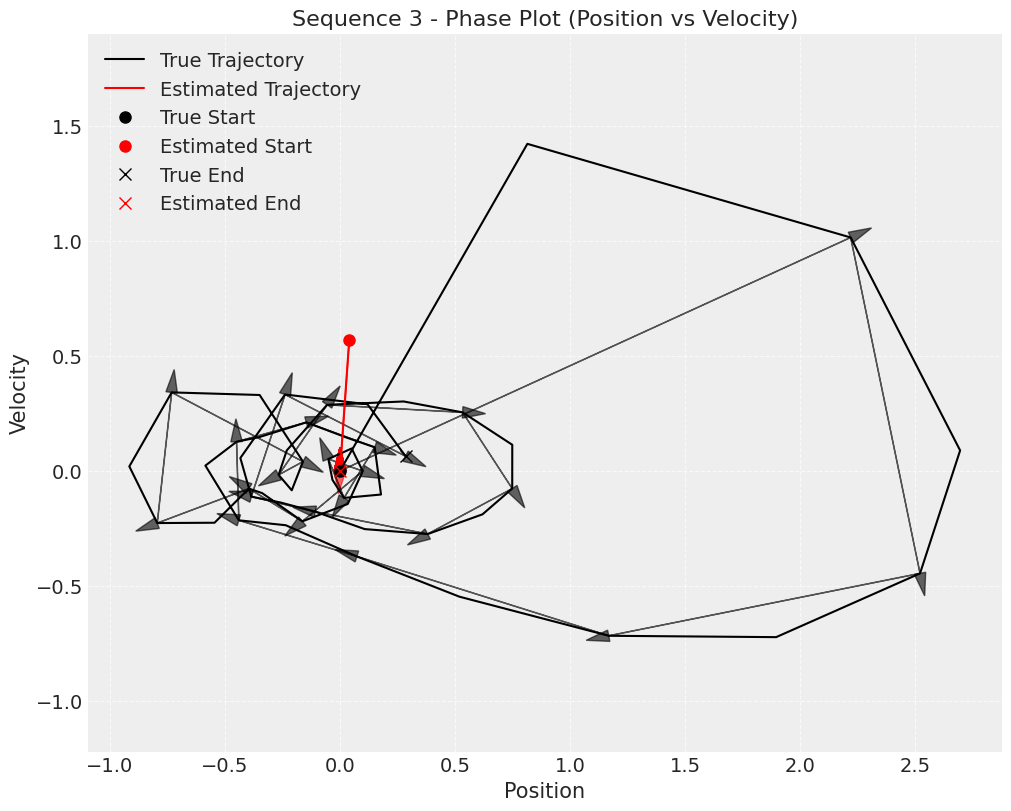

In [15]:
true_params = {
        'a': 0.5,
        'b': 0.3,
        'c': 0.1,
        'noise_std': 0.05
    }

visualize_scrolling_model_results(mcmc, U, Y, xs, true_params)


In [16]:
def visualize_scrolling_model_results(mcmc, U, Y, true_states, true_params=None):
    """
    Visualize LGSSM inference results for scrolling data with comparison to true hidden states.
    """
    # Extract MCMC samples
    samples = mcmc.get_samples()
    
    # Get dimensions
    num_sequences, sequence_length = Y.shape
    state_dim = 2  # Position and velocity
    
    # Get parameter estimates
    a_mean = samples['a'].mean()
    b_mean = samples['b'].mean()
    c_mean = samples['c'].mean()
    qs_mean = samples['qs'].mean(axis=0)
    r_mean = samples['r'].mean()
    
    # Print parameter comparison
    print("Parameter Estimates:")
    print(f"a: {a_mean:.4f}" + (f" (true: {true_params['a']:.4f})" if true_params else ""))
    print(f"b: {b_mean:.4f}" + (f" (true: {true_params['b']:.4f})" if true_params else ""))
    print(f"c: {c_mean:.4f}" + (f" (true: {true_params['c']:.4f})" if true_params else ""))
    print(f"r: {r_mean:.4f}" + (f" (true: {true_params['noise_std']:.4f})" if true_params else ""))
    print(f"qs: {qs_mean}")
    
    # Define system matrices with posterior means
    A_est = np.array([[0, 1], [-c_mean / a_mean, -b_mean / a_mean]])
    B_est = np.array([[0], [1 / a_mean]])
    C_est = np.array([[1.0, 0.0]])  # Assuming we observe the first state
    
    # Define true system matrices if true parameters are provided
    if true_params:
        a_true = true_params['a']
        b_true = true_params['b']
        c_true = true_params['c']
        A_true = np.array([[0, 1], [-c_true / a_true, -b_true / a_true]])
        B_true = np.array([[0], [1 / a_true]])
        C_true = np.array([[1, 1]])  # From your generate_scrolling_data function
    
    # Plot parameter distributions with true values
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    
    # Plot parameter distributions
    axes[0, 0].hist(samples['a'], bins=30, alpha=0.7)
    axes[0, 0].axvline(a_mean, color='r', linestyle='--', label='Estimated')
    if true_params:
        axes[0, 0].axvline(true_params['a'], color='k', linestyle='-', label='True')
    axes[0, 0].set_title('Parameter a')
    axes[0, 0].legend()
    
    axes[0, 1].hist(samples['b'], bins=30, alpha=0.7)
    axes[0, 1].axvline(b_mean, color='r', linestyle='--', label='Estimated')
    if true_params:
        axes[0, 1].axvline(true_params['b'], color='k', linestyle='-', label='True')
    axes[0, 1].set_title('Parameter b')
    axes[0, 1].legend()
    
    axes[1, 0].hist(samples['c'], bins=30, alpha=0.7)
    axes[1, 0].axvline(c_mean, color='r', linestyle='--', label='Estimated')
    if true_params:
        axes[1, 0].axvline(true_params['c'], color='k', linestyle='-', label='True')
    axes[1, 0].set_title('Parameter c')
    axes[1, 0].legend()
    
    axes[1, 1].hist(samples['r'], bins=30, alpha=0.7)
    axes[1, 1].axvline(r_mean, color='r', linestyle='--', label='Estimated')
    if true_params:
        axes[1, 1].axvline(true_params['noise_std'], color='k', linestyle='-', label='True')
    axes[1, 1].set_title('Observation noise r')
    axes[1, 1].legend()
    
    axes[2, 0].hist(samples['qs'][:, 0], bins=30, alpha=0.7)
    axes[2, 0].axvline(qs_mean[0], color='r', linestyle='--')
    axes[2, 0].set_title('Process noise qs[0]')
    
    axes[2, 1].hist(samples['qs'][:, 1], bins=30, alpha=0.7)
    axes[2, 1].axvline(qs_mean[1], color='r', linestyle='--')
    axes[2, 1].set_title('Process noise qs[1]')
    
    plt.tight_layout()
    plt.show()
    
    # Create time array for plotting
    time = np.linspace(0, 50, sequence_length)
    
    # For each sequence, visualize inputs, states, and observations
    for seq_idx in range(min(num_sequences, 3)):  # Limit to first 3 sequences for brevity
        # Create a 3x1 subplot for each sequence
        fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
        
        # Plot input signal
        axes[0].plot(time, U[seq_idx], 'g-', label='Input Signal')
        axes[0].set_title(f'Sequence {seq_idx+1} - Input Signal')
        axes[0].set_ylabel('Input')
        axes[0].legend()
        axes[0].grid(True, linestyle='--', alpha=0.7)
        
        # Extract hidden state estimates for this sequence
        z_states = {}
        z_states[0] = samples[f'z0_{seq_idx}']
        
        for t in range(1, sequence_length):
            key = f'z{seq_idx}_{t}'
            if key in samples:
                z_states[t] = samples[key]
        
        # Create arrays for the mean and credible intervals
        z_mean = np.zeros((sequence_length, state_dim))
        z_lower = np.zeros((sequence_length, state_dim))
        z_upper = np.zeros((sequence_length, state_dim))
        
        # Fill in values for time step 0
        z_mean[0] = z_states[0].mean(axis=0)
        z_lower[0] = np.percentile(z_states[0], 2.5, axis=0)
        z_upper[0] = np.percentile(z_states[0], 97.5, axis=0)
        
        # Fill in values for remaining time steps
        for t in range(1, sequence_length):
            if t in z_states:
                z_mean[t] = z_states[t].mean(axis=0)
                z_lower[t] = np.percentile(z_states[t], 2.5, axis=0)
                z_upper[t] = np.percentile(z_states[t], 97.5, axis=0)
        
        # Plot hidden states
        for dim in range(state_dim):
            label = 'Position' if dim == 0 else 'Velocity'
            color = 'b' if dim == 0 else 'r'
            
            # Plot true state
            axes[1].plot(time, true_states[seq_idx, :, dim], f'k-', 
                         label=f'True {label}')
            
            # Plot estimated state with credible interval
            axes[1].plot(time, z_mean[:, dim], f'{color}-', 
                         label=f'Estimated {label}')
            axes[1].fill_between(time, z_lower[:, dim], z_upper[:, dim], 
                              color=color, alpha=0.2)
        
        axes[1].set_title(f'Sequence {seq_idx+1} - Hidden States')
        axes[1].set_ylabel('State Value')
        axes[1].legend()
        axes[1].grid(True, linestyle='--', alpha=0.7)
        
        # Plot observations and predictions
        # True observation is y from the data
        y_true = Y[seq_idx]
        
        # Predicted observation based on estimated states (using C @ z)
        y_pred = np.array([C_est @ z for z in z_mean])
        y_pred = y_pred.flatten()
        
        # Plot true and predicted observations
        axes[2].plot(time, y_true, 'k.', label='Observed Data')
        axes[2].plot(time, y_pred, 'b-', label='Predicted Output')
        
        # True clean output if we have true parameters
        if true_params:
            y_clean = np.array([C_true @ z for z in true_states[seq_idx]])
            y_clean = y_clean.flatten()
            axes[2].plot(time, y_clean, 'g--', label='True Clean Output')
        
        axes[2].set_title(f'Sequence {seq_idx+1} - Observations')
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('Output')
        axes[2].legend()
        axes[2].grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
        
        # Phase plot (position vs velocity)
        plt.figure(figsize=(10, 8))
        
        # Plot true trajectory
        plt.plot(true_states[seq_idx, :, 0], true_states[seq_idx, :, 1], 'k-', 
                 label='True Trajectory')
        
        # Plot estimated trajectory
        plt.plot(z_mean[:, 0], z_mean[:, 1], 'r-', label='Estimated Trajectory')
        
        # Add direction arrows
        step = max(1, sequence_length // 20)  # Show ~20 arrows
        for t in range(0, sequence_length - step, step):
            # True trajectory arrow
            plt.arrow(true_states[seq_idx, t, 0], true_states[seq_idx, t, 1],
                      true_states[seq_idx, t + step, 0] - true_states[seq_idx, t, 0],
                      true_states[seq_idx, t + step, 1] - true_states[seq_idx, t, 1],
                      head_width=0.05, head_length=0.1, fc='k', ec='k', alpha=0.6)
            
            # Estimated trajectory arrow
            plt.arrow(z_mean[t, 0], z_mean[t, 1],
                      z_mean[t + step, 0] - z_mean[t, 0],
                      z_mean[t + step, 1] - z_mean[t, 1],
                      head_width=0.05, head_length=0.1, fc='r', ec='r', alpha=0.6)
        
        # Mark start points
        plt.plot(true_states[seq_idx, 0, 0], true_states[seq_idx, 0, 1], 'ko', markersize=8, label='True Start')
        plt.plot(z_mean[0, 0], z_mean[0, 1], 'ro', markersize=8, label='Estimated Start')
        
        # Mark end points
        plt.plot(true_states[seq_idx, -1, 0], true_states[seq_idx, -1, 1], 'kx', markersize=8, label='True End')
        plt.plot(z_mean[-1, 0], z_mean[-1, 1], 'rx', markersize=8, label='Estimated End')
        
        plt.title(f'Sequence {seq_idx+1} - Phase Plot (Position vs Velocity)')
        plt.xlabel('Position')
        plt.ylabel('Velocity')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.axis('equal')  # Equal scaling for better visualization
        plt.show()